In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

## Price the American Option, and introduction

The American options are different than the European options due to flexibility in excersing time. That is, at each time step, one needs to compare the immediate exercise value with the corresponding continuing value. 

This problem can be put under the Snell Envelope theory and be formed as a dynamic programming problem. However, one cannot avoid one key step (also the major difficulty) which is calculating the conditional expectation. 

In this work, we apply the Longstaff Schwartz algorithm and apply a few regression methods (Random Forest, polynomial regression etc) to solve one simple problem. 

### Algorithm

We consider the filtered probabilty space $(\mathbb{\Omega}, \mathcal{F},(\mathcal{F}_t)_{0 \leq t \leq T}, \mathbb{P} )$, and we take $\mathbb{P}$ as the risk neutral measure. 

Consider a Bermudan option that can be exercised at dates
$$0=t_0 < t_1 < t_2< ... < t_N =T$$

The option's `discounted payoff` is given by 
$$Z_{t_j}=h_j(X_{t_j})$$
when the option is excersied and the sequence $(X_{t_j})_j, \ X_{t_j} \in \mathbb{R}^d$ is underlying stock prices which is a Markov process. 

The discounted value $(X_{t_j})_{0 \leq j \leq N}$ of this option is 
$$U_{t_j} = \sup_{\tau \in \mathcal{T}_{t_j, T}}\mathbb{E}[Z_{\tau} | \mathcal{F}_{t_j}]$$
The Snell envelope theory tells us the following (the dynamic programming equations)

$$\begin{equation}
\left\{ 
  \begin{aligned}
    U_{t_N} &=Z_{t,N}\\
    U_{t_j} &=\max(Z_{t_j}, \mathbb{E}[U_{t_{j+1}}|\mathcal{F}_{t_j}]) , \  1 \leq j \leq N-1  \\
  \end{aligned}
  \right.
\end{equation}
$$

In terms of the stopping time, this above equation equals the following
$$\begin{equation}
\left\{ 
  \begin{aligned}
    \tau_{t_N} &=t_N=T\\
    \tau_j &=t_j \mathbb{1}_{Z_{t_j} \geq \mathbb{E}[Z_{\tau_{j+1}}|X_{t_j}]} + \tau_{j+1} \mathbb{1}_{Z_{t_j} \leq\mathbb{E}[Z_{\tau_{j+1}}|X_{t_j}]}, \  1 \leq j \leq N-1  \\
  \end{aligned}
  \right.
\end{equation}
$$
Here $\tau_j$ is the smallest optimal stopping time after $t_j$. 
Notice that we have replaced the $\mathcal{F}_{t_j}$ in $\mathbb{E}[Z_{\tau_{j+1}}|\mathcal{F}_{t_j}]$ with the state $X_{t_j}$ due to the Markov setup. 

A total of M samples of $X_{t_j}$ trajectories are sampled, to gether with the ${Z_{t_j}}$'s 

$$\begin{equation}
\left\{ 
  \begin{aligned}
    \hat{\tau}^{ m}_{N} &=t_N=T\\
    \hat{\tau}^{m}_{j} &=t_j \mathbb{1}_{ \lbrace Z^{m}_{t_j} \geq \hat{\mathcal{T}}^{j,M}(X^m_{t_j}) \rbrace } + \hat{\tau}^{m}_{j+1} \mathbb{1}_{\lbrace Z^m_{t_j} \leq\hat{\mathcal{T}}^{j,M}(X^m_{t_j}) \rbrace}, \  1 \leq j \leq N-1  \\
  \end{aligned}
  \right.
\end{equation}
$$

Then, the price of the option is given by the following
$$U^M_0= \max(Z_0, \frac{1}{M}\sum^M_{m=1} Z^m_{\hat{\tau}^m_1})$$



## Example, 1D Black-Scholes
Consider a put option with the following dynamics

$$dS^i_t=rS_t^i dt + \sigma S^i_t dW^i_t$$
with the parameters set up below. 

It is a put option with strike $K$. 

In [2]:
#Consider a one dim example first. This is the Black and Scholes' model
# The reference solution is 11.987
T=1.0; K=110; S0=100; 
sigma=0.25;N=11;dt=T/(N-1); sqrt_dt= np.sqrt(dt)
Ndates=np.linspace(0,1,N);
r=0.1; 
M=int(5*10**5)

## Generating the stock price

In [3]:
S=np.zeros((M,N)); S[:,0]=np.ones(M)*S0
for i in range(N-1): 
    S[:,i+1]=S[:,i]+r*S[:,i]*dt+sqrt_dt*sigma*S[:,i]*np.random.standard_normal(size=M)

In [4]:
def pay_off(X,timeslot,K=110):
    return np.maximum(K-X,0)*np.exp(-r*timeslot)

### A quick look at the second to last timestep

In [45]:
xtemp=S[:,-2]; xtemp=xtemp.reshape(xtemp.size,1)
ztemp=Z_vec[:,-1]; 
rf=RandomForestRegressor(n_estimators=10,min_samples_leaf=1,max_depth=20, n_jobs=-1)
### This regN function is the conditional expectation function we take at step N-1
regressor=rf.fit(xtemp,ztemp)
ztemp_pred=regressor.predict(xtemp)

Text(0.5, 1.0, 'Terminal case')

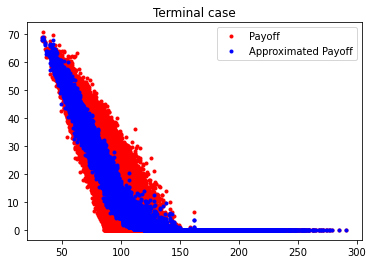

In [54]:
plt.plot(xtemp, ztemp , 'r.',label='Payoff')
plt.plot(xtemp, ztemp_pred, 'b.',label='Approximated Payoff')
plt.legend(loc='upper right')
plt.title('Terminal case')

## Setting up $\tau$ and $Z$

In [5]:
tau_vec=np.zeros((M,N)); tau_vec[:,-1]= np.ones(M)*Ndates[-1]
Z_vec=np.zeros((M,N)); 
Z_tau=np.zeros((M,N)); 
for i in range(0,N):
    Z_temp=pay_off(S[:,i],Ndates[i]);
    Z_tau[:,i]=Z_temp
    Z_vec[:,i]=Z_temp

## Using Random Forest as the regressor

In [27]:
def AmericanOption(N,Z_vec,Z_tau,S):
    z_vec=np.copy(Z_vec); 
    z_tau=np.copy(Z_tau)
    reg_list=[]
    for i in range(N-1,1,-1): # The index starts with N-1 ends with 1 
        xtemp=S[:,i-1]; xtemp=xtemp.reshape(xtemp.size,1)
        ztemp=z_tau[:,i]; #ztemp=ztemp.reshape(ztemp.size,1) ## The subindex is tj
        
        rf=RandomForestRegressor(n_estimators=10,min_samples_leaf=100,max_depth=5,n_jobs=-1); 

        reg=rf.fit(xtemp,ztemp)
        z_pred=reg.predict(xtemp)
        
        idx_continue=(z_vec[:,i-1]<z_pred); 
        z_tau[:,i-1][idx_continue]=z_tau[:,i][idx_continue]
        
        reg_list.append(reg)
    
    return z_tau, reg_list

In [28]:
res1,res2=AmericanOption(N,Z_vec,Z_tau,S)

In [29]:
## The Random foreset method gives a result that's better, but one needs to find tune it.
## the larger/smaller max_depth term tends to overfit/underfit
np.mean(res1[:,1])

11.99413210376091

In [56]:
(11.994-11.987)/11.987

0.0005839659631266933

### Comparing with Polynomial approximation

In [38]:
def AmericanOption_poly(N,Z_vec,Z_tau,S):
    reg_list=[]
    z_vec=np.copy(Z_vec); 
    z_tau=np.copy(Z_tau)
    for i in range(N-1,1,-1): # The index starts with N-1 ends with 1 
        xtemp=S[:,i-1]; #xtemp=xtemp.reshape(xtemp.size,1)
        ztemp=z_tau[:,i]; #ztemp=ztemp.reshape(ztemp.size,1) ## The subindex is tj
        
        rf=np.polyfit(xtemp,ztemp, 3)
        z_pred=np.polyval(rf,xtemp)
   
        idx_continue=(z_vec[:,i-1]<z_pred); 
        z_tau[:,i-1][idx_continue]=z_tau[:,i][idx_continue]
        
        reg_list.append(rf)
    
    return z_tau, reg_list

In [39]:
res1,res2=AmericanOption_poly(N,Z_vec,Z_tau,S)

In [40]:
np.mean(res1[:,1])

11.880296656539402

In [41]:
# The polynomial method gives a 0.5% accuracy
(11.94-11.88)/11.94

0.005025125628140597